In [ ]:
!pip install trl

In [ ]:
import json
import random
from sklearn.model_selection import train_test_split

# --- Configuration ---
COLORS = ['R', 'G', 'B']
ALLOWED_TRANSITIONS = {'R': ['G'], 'G': ['B'], 'B': ['R', 'G']}
SEQUENCE_LENGTH = 40

# New: Dynamic prompt length configuration
MIN_PROMPT_LENGTH = 1
MAX_PROMPT_LENGTH = 20

PRETRAIN_TOTAL_SIZE = 20_000
SFT_SIZE = 1000  # Will be derived from DPO data
DPO_SIZE = 1000

# --- Core Logic (Unchanged) ---

def generate_valid_sequence(length, sequence=None):
    """Generates or continues a valid sequence of colors."""
    if sequence is None:
        # Start with a character that allows for diverse paths
        sequence = [random.choice(['R', 'B'])]

    # Ensure sequence is a list to allow extension
    if isinstance(sequence, str):
        sequence = list(sequence)

    while len(sequence) < length:
        last_color = sequence[-1]
        next_color = random.choice(ALLOWED_TRANSITIONS[last_color])
        sequence.append(next_color)
    return "".join(sequence)

def calculate_diversity_score(sequence):
    """Calculates diversity based on the frequency of 'BG' transitions."""
    bg_transitions = sequence.count('BG')
    # Avoid division by zero for single-character sequences
    return bg_transitions / (len(sequence) - 1) if len(sequence) > 1 else 0

# --- Dataset Generation Functions (Pre-train is unchanged) ---

def create_pretrain_dataset():
    """Generates pre-training data and splits it into train and test sets."""
    print(f"Generating {PRETRAIN_TOTAL_SIZE} sequences for pre-training...")
    all_sequences = [generate_valid_sequence(SEQUENCE_LENGTH) for _ in range(PRETRAIN_TOTAL_SIZE)]

    train_seqs, test_seqs = train_test_split(all_sequences, test_size=0.1, random_state=42)

    with open("pretrain_train.jsonl", 'w') as f:
        for seq in train_seqs:
            f.write(json.dumps({"text": seq}) + "\n")
    print(f"Saved {len(train_seqs)} sequences to pretrain_train.jsonl")

    with open("pretrain_test.jsonl", 'w') as f:
        for seq in test_seqs:
            f.write(json.dumps({"text": seq}) + "\n")
    print(f"Saved {len(test_seqs)} sequences to pretrain_test.jsonl")


# --- REVISED FUNCTION ---
def create_dpo_and_sft_datasets():
    """
    Generates DPO and SFT datasets with dynamic-length prompts and a
    prompt/completion structure.
    """
    print(f"Generating {DPO_SIZE} preference pairs for DPO...")
    preference_pairs = []

    while len(preference_pairs) < DPO_SIZE:
        # 1. Generate a prompt with a dynamic length
        prompt_length = random.randint(MIN_PROMPT_LENGTH, MAX_PROMPT_LENGTH)
        prompt = generate_valid_sequence(prompt_length)

        # 2. Generate two different continuations from that same prompt
        seq1_full = generate_valid_sequence(SEQUENCE_LENGTH, sequence=prompt)
        seq2_full = generate_valid_sequence(SEQUENCE_LENGTH, sequence=prompt)

        # Ensure the generated sequences are actually different
        if seq1_full == seq2_full:
            continue

        # 3. Score the full sequences to determine preference
        score1, score2 = calculate_diversity_score(seq1_full), calculate_diversity_score(seq2_full)

        # Ensure scores are different to create a clear preference
        if score1 == score2:
            continue

        # 4. Assign chosen and rejected based on the score
        chosen_full, rejected_full = (seq1_full, seq2_full) if score1 > score2 else (seq2_full, seq1_full)

        # 5. Extract the completions (the part after the prompt)
        chosen_completion = chosen_full[len(prompt):]
        rejected_completion = rejected_full[len(prompt):]

        preference_pairs.append({
            "prompt": prompt,
            "chosen": chosen_completion,
            "rejected": rejected_completion
        })

    # Save the DPO dataset with the new structure
    with open("dpo.jsonl", 'w') as f:
        for pair in preference_pairs:
            f.write(json.dumps(pair) + "\n")
    print(f"DPO preference dataset saved to dpo.jsonl")

    # --- Create the SFT dataset from the 'chosen' completions ---
    print(f"Generating {SFT_SIZE} examples for SFT...")
    # Sort pairs by the diversity of their 'chosen' sequence
    # To do this, we need to reconstruct the full sequence for scoring
    preference_pairs.sort(
        key=lambda p: calculate_diversity_score(p['prompt'] + p['chosen']),
        reverse=True
    )

    # Take the top SFT_SIZE examples
    sft_dataset = preference_pairs[:SFT_SIZE]

    # Save the SFT dataset with the prompt/completion structure
    with open("sft.jsonl", 'w') as f:
        for pair in sft_dataset:
            # We only need the prompt and the chosen completion for SFT
            sft_entry = {"text": pair['prompt'] + pair['chosen']}
            f.write(json.dumps(sft_entry) + "\n")
    print(f"SFT dataset with {len(sft_dataset)} sequences saved to sft.jsonl")


# --- Main Execution ---
if __name__ == "__main__":
    print("--- Starting Updated Dataset Generation ---")
    create_pretrain_dataset()
    print("-" * 20)
    create_dpo_and_sft_datasets()
    print("-" * 20)
    print("All datasets generated successfully. ✅")

--- Starting Updated Dataset Generation ---
Generating 20000 sequences for pre-training...
Saved 18000 sequences to pretrain_train.jsonl
Saved 2000 sequences to pretrain_test.jsonl
--------------------
Generating 1000 preference pairs for DPO...
DPO preference dataset saved to dpo.jsonl
Generating 1000 examples for SFT...
SFT dataset with 1000 sequences saved to sft.jsonl
--------------------
All datasets generated successfully. ✅


In [ ]:
import wandb
wandb.login(key="api-key")

In [ ]:
import os
import json
import random
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    GPT2Config,
    GPT2LMHeadModel,
)
from torch.utils.data import Dataset
from typing import Dict, List, Any

# --- Configuration ---
PRETRAIN_FILE = "pretrain.jsonl"
MODEL_OUTPUT_DIR = "pretrained-color-model"

# Define the "grammar" rules to check against
ALLOWED_TRANSITIONS = {
    'R': ['G'],
    'G': ['B'],
    'B': ['R', 'G']
}
VOCAB = ['R', 'G', 'B']

# --- 1. Create a Manual Character-Level Tokenizer ---
import json
import os
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Union

from transformers.tokenization_utils import AddedToken, PreTrainedTokenizer

class ManualCharTokenizer(PreTrainedTokenizer):
    def __init__(self, characters: Sequence[str], model_max_length: int, **kwargs):
        """Character tokenizer for Hugging Face transformers.

        Args:
            characters (Sequence[str]): List of desired characters. Any character which
                is not included in this list will be replaced by a special token called
                [UNK] with id=6. Following are list of all of the special tokens with
                their corresponding ids:
                    "[CLS]": 0
                    "[SEP]": 1
                    "[BOS]": 2
                    "[MASK]": 3
                    "[PAD]": 4
                    "[RESERVED]": 5
                    "[UNK]": 6
                an id (starting at 7) will be assigned to each character.

            model_max_length (int): Model maximum sequence length.
        """
        self.characters = characters
        self.model_max_length = model_max_length
        bos_token = AddedToken("[BOS]", lstrip=False, rstrip=False)
        eos_token = AddedToken("[SEP]", lstrip=False, rstrip=False)
        sep_token = AddedToken("[SEP]", lstrip=False, rstrip=False)
        cls_token = AddedToken("[CLS]", lstrip=False, rstrip=False)
        pad_token = AddedToken("[PAD]", lstrip=False, rstrip=False)
        unk_token = AddedToken("[UNK]", lstrip=False, rstrip=False)

        mask_token = AddedToken("[MASK]", lstrip=True, rstrip=False)

        self._vocab_str_to_int = {
            "[CLS]": 0,
            "[SEP]": 1,
            "[BOS]": 2,
            "[MASK]": 3,
            "[PAD]": 4,
            "[RESERVED]": 5,
            "[UNK]": 6,
            **{ch: i + 7 for i, ch in enumerate(characters)},
        }
        self._vocab_int_to_str = {v: k for k, v in self._vocab_str_to_int.items()}

        super().__init__(
            bos_token=bos_token,
            eos_token=eos_token,
            sep_token=sep_token,
            cls_token=cls_token,
            pad_token=pad_token,
            mask_token=mask_token,
            unk_token=unk_token,
            add_prefix_space=False,
            model_max_length=model_max_length,
            **kwargs,
        )

    @property
    def vocab_size(self) -> int:
        return len(self._vocab_str_to_int)

    def get_vocab(self):
        return self._vocab_str_to_int

    def _tokenize(self, text: str) -> List[str]:
        return list(text)

    def _convert_token_to_id(self, token: str) -> int:
        return self._vocab_str_to_int.get(token, self._vocab_str_to_int["[UNK]"])

    def _convert_id_to_token(self, index: int) -> str:
        return self._vocab_int_to_str[index]

    def convert_tokens_to_string(self, tokens):
        return "".join(tokens)

    def build_inputs_with_special_tokens(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        result = cls + token_ids_0 + sep
        if token_ids_1 is not None:
            result += token_ids_1 + sep
        return result

    def get_special_tokens_mask(
        self,
        token_ids_0: List[int],
        token_ids_1: Optional[List[int]] = None,
        already_has_special_tokens: bool = False,
    ) -> List[int]:
        if already_has_special_tokens:
            return super().get_special_tokens_mask(
                token_ids_0=token_ids_0,
                token_ids_1=token_ids_1,
                already_has_special_tokens=True,
            )

        result = [1] + ([0] * len(token_ids_0)) + [1]
        if token_ids_1 is not None:
            result += ([0] * len(token_ids_1)) + [1]
        return result

    def create_token_type_ids_from_sequences(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]

        result = len(cls + token_ids_0 + sep) * [0]
        if token_ids_1 is not None:
            result += len(token_ids_1 + sep) * [1]
        return result

    def get_config(self) -> Dict:
        return {
            "char_ords": [ord(ch) for ch in self.characters],
            "model_max_length": self.model_max_length,
        }

    @classmethod
    def from_config(cls, config: Dict) -> "CharacterTokenizer":
        cfg = {}
        cfg["characters"] = [chr(i) for i in config["char_ords"]]
        cfg["model_max_length"] = config["model_max_length"]
        return cls(**cfg)

    def save_pretrained(self, save_directory: Union[str, os.PathLike], **kwargs):
        cfg_file = Path(save_directory) / "tokenizer_config.json"
        cfg = self.get_config()
        with open(cfg_file, "w") as f:
            json.dump(cfg, f, indent=4)

    @classmethod
    def from_pretrained(cls, save_directory: Union[str, os.PathLike], **kwargs):
        cfg_file = Path(save_directory) / "tokenizer_config.json"
        with open(cfg_file) as f:
            cfg = json.load(f)
        return cls.from_config(cfg)

# Instantiate our new tokenizer
chars = VOCAB # This is character vocab
model_max_length = 2048
tokenizer = ManualCharTokenizer(chars, model_max_length)

print("Manual character-level tokenizer created.")
print(f"Vocabulary size: {len(tokenizer)}")


# --- 2. Load and Prepare the Dataset ---

# Load the dataset from the JSONL file
# Assuming you have split your data into train and test files
train_dataset = load_dataset('json', data_files="pretrain_train.jsonl", split='train')
test_dataset = load_dataset('json', data_files="pretrain_test.jsonl", split='train')

# Tokenize the dataset
def tokenize_function(examples):
    # Our tokenizer's __call__ method handles batching and returns unpadded input_ids
    return tokenizer(examples['text'], truncation=True, max_length=512)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

# Create a data collator for causal language modeling
# This collator will now use our tokenizer's .pad() method correctly
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)


# --- 3. Define the Model ---

# We'll use a small GPT-2 model configured for our tiny vocabulary
model_config = GPT2Config(
    model_type="gpt2",
    vocab_size=len(tokenizer),
    n_positions=512,
    n_embd=256, # Smaller embedding size
    n_layer=6,  # Fewer layers
    n_head=4,   # Fewer attention heads
    tie_word_embeddings=False
)

model = GPT2LMHeadModel(config=model_config)
print(f"Model initialized with {model.num_parameters():,} parameters.")


# --- 4. Define the Metric Calculation ---

def calculate_local_rule_adherence(model, tokenizer, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Generates a sequence and calculates the percentage of valid transitions.
    """
    model.to(device)
    model.eval() # Set model to evaluation mode

    # Generate a long sequence to test adherence
    start_char = random.choice(['R', 'B'])
    start_token = torch.tensor([tokenizer.encode(start_char)], device=device)

    # generate() is a powerful method for autoregressive generation
    generated_ids = model.generate(
        start_token,
        max_length=40,
        do_sample=True,
        top_k=5, # Limit sampling to top-k tokens to avoid bad choices
        pad_token_id=tokenizer.pad_token_id
    )

    generated_text = tokenizer.decode(generated_ids[0].tolist(), skip_special_tokens=True)

    # Calculate adherence
    valid_transitions = 0
    total_transitions = len(generated_text) - 1

    if total_transitions <= 0:
        return 0.0

    for i in range(total_transitions):
        current_char = generated_text[i]
        next_char = generated_text[i+1]

        if current_char in ALLOWED_TRANSITIONS and next_char in ALLOWED_TRANSITIONS[current_char]:
            valid_transitions += 1

    adherence = (valid_transitions / total_transitions) * 100
    return adherence

# We need a custom compute_metrics function for the Trainer
def compute_metrics(eval_pred):
    """
    This function will be called by the Trainer at each evaluation.
    """
    adherence_score = calculate_local_rule_adherence(model, tokenizer)
    return {"local_rule_adherence": adherence_score}


# --- 5. Train the Model ---

training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_DIR,
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=256,
    save_steps=18,
    save_total_limit=2,
    logging_steps=18,
    eval_strategy="steps", # Renamed from eval_strategy
    eval_steps=18,
    load_best_model_at_end=True,
    metric_for_best_model="local_rule_adherence",
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
)

print("--- Starting Pre-training ---")
trainer.train()

# --- 6. Save Final Model and Tokenizer ---
print("--- Pre-training Complete ---")
trainer.save_model(MODEL_OUTPUT_DIR)
tokenizer.save_pretrained(MODEL_OUTPUT_DIR)
print(f"Final model and tokenizer saved to {MODEL_OUTPUT_DIR}")

# --- 7. Final Test of the Trained Model ---
print("\n--- Testing Final Model ---")
final_adherence = calculate_local_rule_adherence(model, tokenizer)
print(f"Final Local Rule Adherence: {final_adherence:.2f}%")
print("Generating an example sequence:")

# Generate one last sample
start_char = random.choice(['R', 'B'])
start_token = torch.tensor([tokenizer.encode(start_char)], device=model.device)
generated_ids = model.generate(start_token, max_length=40, do_sample=False, pad_token_id=tokenizer.pad_token_id)
print(tokenizer.decode(generated_ids[0].tolist(), skip_special_tokens=True))

Manual character-level tokenizer created.
Vocabulary size: 10
Model initialized with 4,875,264 parameters.
--- Starting Pre-training ---


Step,Training Loss,Validation Loss,Local Rule Adherence
18,0.652700,0.372674,100.000000
36,0.343800,0.328805,97.222222
54,0.323400,0.321196,94.285714


--- Pre-training Complete ---
Final model and tokenizer saved to pretrained-color-model

--- Testing Final Model ---
Final Local Rule Adherence: 72.09%
Generating an example sequence:
RBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGBGB


In [ ]:
import torch
import json
import random
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)

# --- Configuration ---
PRETRAINED_MODEL_DIR = "pretrained-color-model"
SFT_DATA_FILE = "sft.jsonl"
SFT_OUTPUT_DIR = "sft-color-model"

# Rules needed for metrics
ALLOWED_TRANSITIONS = {'R': ['G'], 'G': ['B'], 'B': ['R', 'G']}

model = AutoModelForCausalLM.from_pretrained(PRETRAINED_MODEL_DIR)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# --- 2. Load and Prepare SFT Dataset ---
sft_dataset = load_dataset('json', data_files=SFT_DATA_FILE, split='train')

tokenized_sft_dataset = sft_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

def generate_and_evaluate(model, tokenizer):
    """Generates a sequence and calculates key metrics."""
    model.to(device)
    model.eval() # Set model to evaluation mode

    # Generate a long sequence to test adherence
    start_char = random.choice(['R', 'B'])
    start_token = torch.tensor([tokenizer.encode(start_char)], device=device)

    # generate() is a powerful method for autoregressive generation
    generated_ids = model.generate(
        start_token,
        max_length=40,
        do_sample=True,
        top_k=5, # Limit sampling to top-k tokens to avoid bad choices
        pad_token_id=tokenizer.pad_token_id
    )

    generated_text = tokenizer.decode(generated_ids[0].tolist(), skip_special_tokens=True)

    # Calculate adherence
    valid_transitions = 0
    total_transitions = len(generated_text) - 1

    if total_transitions <= 0:
        return 0.0

    for i in range(total_transitions):
        current_char = generated_text[i]
        next_char = generated_text[i+1]

        if current_char in ALLOWED_TRANSITIONS and next_char in ALLOWED_TRANSITIONS[current_char]:
            valid_transitions += 1

    adherence = (valid_transitions / total_transitions) * 100

    # Metric 2: Diversity Score
    diversity = calculate_diversity_score(generated_text)

    return {"local_rule_adherence": adherence, "global_diversity_score": diversity}

def compute_metrics_next(eval_pred):
    return generate_and_evaluate(model, tokenizer)

# --- 4. Train the Model ---
training_args = TrainingArguments(
    output_dir=SFT_OUTPUT_DIR,
    overwrite_output_dir=True,
    num_train_epochs=10, # Fewer epochs for fine-tuning
    per_device_train_batch_size=512,
    save_steps=6,
    save_total_limit=2,
    logging_steps=6,
    eval_strategy="steps",
    eval_steps=6,
    load_best_model_at_end=True,
    metric_for_best_model="global_diversity_score",
    greater_is_better=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_sft_dataset,
    eval_dataset=tokenized_sft_dataset, # Evaluate on the same small dataset
    compute_metrics=compute_metrics_next,
)

print("--- Starting Supervised Fine-Tuning (SFT) ---")
trainer.train()

# --- 5. Save Final Model ---
trainer.save_model(SFT_OUTPUT_DIR)
tokenizer.save_pretrained(SFT_OUTPUT_DIR)
print(f"SFT model saved to {SFT_OUTPUT_DIR}")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

--- Starting Supervised Fine-Tuning (SFT) ---


Step,Training Loss,Validation Loss,Local Rule Adherence,Global Diversity Score
6,0.443400,0.398082,97.297297,0.000000
12,0.369200,0.352447,97.297297,0.486486
18,0.345300,0.337946,97.297297,0.486486


SFT model saved to sft-color-model


In [ ]:
# --- Configuration ---
# Using a public model for reproducibility.
# Ensure your JSONL file has "prompt", "chosen", and "rejected" fields.
DPO_DATA_FILE = "dpo.jsonl"
# Directory where the final DPO model will be saved.
DPO_MODEL_OUTPUT_DIR = "dpo-model-output"

# --- 1. Load Model and Tokenizer ---
print("Loading pre-trained model and tokenizer...")

# For DPOTrainer, we need the base model which will be trained.
model_dpo = AutoModelForCausalLM.from_pretrained(PRETRAINED_MODEL_DIR)
model_dpo.to(device)

# --- 2. Load the Preference Dataset ---
print("Loading preference dataset for DPO...")
dpo_dataset = load_dataset('json', data_files=DPO_DATA_FILE, split='train')

# --- 3. Set up Training Arguments using DPOConfig ---
# DPOConfig is a subclass of TrainingArguments with DPO-specific settings.
training_args = DPOConfig(
    output_dir=DPO_MODEL_OUTPUT_DIR,
    per_device_train_batch_size=2, # DPO can be more memory intensive
    num_train_epochs=1,
    gradient_accumulation_steps=2,
    learning_rate=5e-6, # Lower learning rate is often better for DPO
    report_to="tensorboard",
    logging_steps=50,
    eval_strategy="no",
    save_strategy="epoch",
    # The beta parameter is a key hyperparameter in DPO.
    # It controls how much the model stays close to the reference model.
    # A common value is 0.1.
    beta=0.1,
)

# --- 4. Initialize and Run the DPOTrainer ---
print("--- Starting Direct Preference Optimization (DPO) Training ---")

# The DPOTrainer handles the DPO loss calculation automatically.
# It requires the model, an optional ref_model, the tokenizer,
# training args, and the dataset.
dpo_tokenizer = copy.deepcopy(tokenizer)

trainer = DPOTrainer(
    model=model_dpo,
    ref_model=None, # If None, the trainer will create a reference model internally
    args=training_args,
    train_dataset=dpo_dataset,
    processing_class=dpo_tokenizer,
)

trainer.train()

# --- 5. Save the Final Model ---
print("--- DPO Training Complete ---")
trainer.save_model(DPO_MODEL_OUTPUT_DIR)
tokenizer.save_pretrained(DPO_MODEL_OUTPUT_DIR)
print(f"DPO model and tokenizer saved to {DPO_MODEL_OUTPUT_DIR}")

Loading pre-trained model and tokenizer...
Loading preference dataset for DPO...
--- Starting Direct Preference Optimization (DPO) Training ---


Step,Training Loss
50,0.381400
100,0.195000
150,0.163700
200,0.144900
250,0.128300


--- DPO Training Complete ---
DPO model and tokenizer saved to dpo-model-output


In [ ]:
import torch
import numpy as np
import random
from transformers import AutoModelForCausalLM
from scipy.stats import entropy

# --- Configuration ---
SFT_MODEL_DIR = "sft-color-model"           # Directory where the SFT model was saved
RLHF_MODEL_DIR = "dpo-model-output"         # Directory where the RLHF model was saved
VOCAB = ['R', 'G', 'B']                     # The vocabulary for our tokenizer
NUM_SAMPLES = 200                           # Number of sequences to generate for evaluation

# --- Helper Functions ---
ALLOWED_TRANSITIONS = {'R': ['G'], 'G': ['B'], 'B': ['R', 'G']}

def calculate_diversity_score(sequence: str) -> float:
    """Calculates the frequency of the complexity-inducing 'B->G' transition."""
    bg_transitions = sequence.count('BG')
    return bg_transitions / (len(sequence) - 1) if len(sequence) > 1 else 0.0

def calculate_rule_adherence(sequence: str) -> float:
    """Calculates the percentage of valid transitions in a sequence."""
    valid_transitions = 0
    total_transitions = len(sequence) - 1
    if total_transitions <= 0:
        return 100.0
    for i in range(total_transitions):
        current_char = sequence[i]
        next_char = sequence[i+1]
        if current_char in ALLOWED_TRANSITIONS and next_char in ALLOWED_TRANSITIONS[current_char]:
            valid_transitions += 1
    return (valid_transitions / total_transitions) * 100.0

def generate_samples(model, tokenizer, num_samples: int) -> list[str]:
    """Generates a list of sequences from a given model."""
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    sequences = []
    print(f"Generating {num_samples} samples...")
    for _ in range(num_samples):
        # Start generation with a random valid character
        start_char = random.choice(['R', 'B'])
        input_ids = torch.tensor([tokenizer.encode(start_char)], device=device)

        # Generate sequence
        generated_ids = model.generate(
            input_ids,
            max_length=40,
            do_sample=True,
            top_k=5,
            pad_token_id=tokenizer.pad_token_id
        )
        # Decode and add to the list
        seq = tokenizer.decode(generated_ids[0].tolist(), skip_special_tokens=True)
        sequences.append(seq)
    return sequences

def analyze_results(model_name: str, sequences: list[str]):
    """Calculates and prints all key metrics for a list of generated sequences."""
    # Metric 1: Global "Preference" Score (The primary task goal)
    diversity_scores = [calculate_diversity_score(s) for s in sequences]
    avg_diversity = np.mean(diversity_scores)
    max_diversity = np.max(diversity_scores)

    # Metric 2: Local Rule Adherence (Sanity check)
    adherence_scores = [calculate_rule_adherence(s) for s in sequences]
    avg_adherence = np.mean(adherence_scores)

    # Metric 3: Output Entropy (Creativity / Variety)
    unique_sequences, counts = np.unique(sequences, return_counts=True)
    probs = counts / len(sequences)
    output_entropy = entropy(probs, base=2)

    print(f"--- Results for {model_name} ---")
    print(f"Average Global Preference Scored: {avg_diversity:.4f}")
    print(f"Maximum Diversity Score Found:  {max_diversity:.4f}")
    print(f"Average Local Rule Adherence:   {avg_adherence:.2f}%")
    print(f"Output Entropy:    {output_entropy:.4f} bits")
    print("-" * 40)

# --- Main Comparison Script ---
if __name__ == "__main__":

    # Load the BASE model
    print(f"Loading BASE model from {MODEL_OUTPUT_DIR}...")
    base_model = AutoModelForCausalLM.from_pretrained(MODEL_OUTPUT_DIR)
    base_model.to(device)

    # Load the SFT model
    print(f"Loading SFT model from {SFT_MODEL_DIR}...")
    sft_model = AutoModelForCausalLM.from_pretrained(SFT_MODEL_DIR)
    sft_model.to(device)

    # Load the DPO model
    print(f"Loading DPO model from {DPO_MODEL_OUTPUT_DIR}...")
    dpo_model = AutoModelForCausalLM.from_pretrained(DPO_MODEL_OUTPUT_DIR)
    dpo_model.to(device)

    # Generate sequences from both models
    sft_sequences = generate_samples(sft_model, tokenizer, NUM_SAMPLES)
    dpo_sequences = generate_samples(dpo_model, tokenizer, NUM_SAMPLES)
    base_sequences = generate_samples(base_model, tokenizer, NUM_SAMPLES)

    # Analyze and print the final comparison
    print("\n" + "="*40)
    print("           FINAL MODEL COMPARISON")
    print("="*40)
    analyze_results("SFT Model (The Imitator)", sft_sequences)
    analyze_results("DPO Model (The Explorer)", dpo_sequences)
    analyze_results("BASE Model (The Base)", base_sequences)

Loading BASE model from pretrained-color-model...
Loading SFT model from sft-color-model...
Loading DPO model from dpo-model-output...
Generating 200 samples...
Generating 200 samples...
Generating 200 samples...

           FINAL MODEL COMPARISON
--- Results for SFT Model (The Imitator) ---
Average Global Preference Scored: 0.2966
Maximum Diversity Score Found:  0.4595
Average Local Rule Adherence:   92.62%
Output Entropy:    7.6439 bits
----------------------------------------
--- Results for DPO Model (The Explorer) ---
Average Global Preference Scored: 0.4551
Maximum Diversity Score Found:  0.5000
Average Local Rule Adherence:   88.44%
Output Entropy:    6.6649 bits
----------------------------------------
--- Results for BASE Model (The Base) ---
Average Global Preference Scored: 0.2434
Maximum Diversity Score Found:  0.4118
Average Local Rule Adherence:   86.66%
Output Entropy:    7.6439 bits
----------------------------------------


Using device: cuda
Loading tokenizer from dpo-model-output...
Loading BASE model from pretrained-color-model...
Loading SFT model from sft-color-model...
Loading DPO model from dpo-model-output...

--- Generating for BASE Model ---
Generating 20 sequences of length 20...

--- Generating for SFT Model ---
Generating 20 sequences of length 20...

--- Generating for DPO Model ---
Generating 20 sequences of length 20...
Creating subplot image...


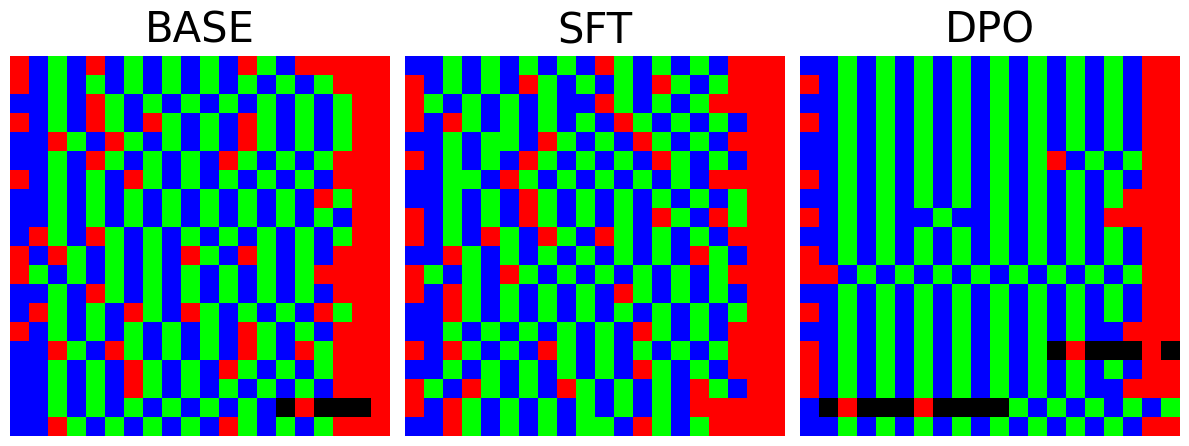


Subplot image saved as 'model_comparison_subplots.png'


In [ ]:
import torch
import random
import os
from transformers import AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
# Dictionary of model names and their corresponding directory paths
MODEL_DIRS = {
    "BASE": "pretrained-color-model",
    "SFT": "sft-color-model",
    "DPO": "dpo-model-output"
}

# We will generate 20 sequences of 20 tokens for each model
NUM_SEQUENCES_PER_MODEL = {
    "BASE": 20,
    "SFT": 20,
    "DPO": 20
}
SEQUENCE_LENGTH = 20

OUTPUT_FILENAME = "model_comparison_subplots.png"

# Define the mapping from characters to RGB colors
COLOR_MAP = {
    'R': (255, 0, 0),     # Red
    'G': (0, 255, 0),     # Green
    'B': (0, 0, 255),     # Blue
    '[UNK]': (0, 0, 0),   # Black for unknown/special tokens
}

def generate_sequences(model, tokenizer, device, num_to_generate, length):
    """Generates a specified number of sequences from a given model."""
    model.to(device)
    model.eval()

    sequences = []
    print(f"Generating {num_to_generate} sequences of length {length}...")
    for _ in range(num_to_generate):
        start_char = random.choice(['R', 'B'])
        input_ids = torch.tensor([tokenizer.encode(start_char)], device=device)

        with torch.no_grad():
            generated_ids = model.generate(
                input_ids,
                max_length=length,
                do_sample=True,
                top_k=5,
                pad_token_id=tokenizer.pad_token_id
            )
        sequence = tokenizer.decode(generated_ids[0].tolist(), skip_special_tokens=True)
        # Ensure the sequence is exactly the desired length for the image grid
        # Note: .ljust is a string method and pads with the character 'R' here.
        sequences.append(sequence.ljust(length, 'R')[:length]) # Pad if shorter, truncate if longer

    return sequences

def create_subplot_image(model_sequences, filename):
    """
    Creates a 1x3 subplot image from sequences generated by different models.
    Each subplot is a 20x20 grid representing the model's output.
    """
    num_models = len(model_sequences)

    # Create a figure and a set of subplots (1 row, num_models columns)
    # The figsize is adjusted for better aesthetics
    fig, axes = plt.subplots(1, num_models, figsize=(num_models * 4, 5))

    # Ensure 'axes' is an array even if there's only one model
    if num_models == 1:
        axes = [axes]

    print("Creating subplot image...")

    # Iterate through the models' sequences and the corresponding axes
    for ax, (model_name, sequences) in zip(axes, model_sequences.items()):
        # Convert character sequences to a list of RGB pixel rows
        pixel_rows = []
        for seq in sequences:
            # Ensure sequence is exactly SEQUENCE_LENGTH and map chars to colors
            row = [COLOR_MAP.get(char, COLOR_MAP['[UNK]']) for char in seq[:SEQUENCE_LENGTH]]
            pixel_rows.append(row)

        # Create a NumPy array from the pixel data. Shape will be (20, 20, 3)
        image_array = np.array(pixel_rows, dtype=np.uint8)

        # Display the image on the current subplot
        ax.imshow(image_array)

        # Set the title for the subplot
        ax.set_title(model_name, fontsize=30, pad=10)

        # Turn off the axis ticks and labels for a cleaner look
        ax.axis('off')

    # Adjust layout to prevent titles/plots from overlapping and add a main title
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect to make space for suptitle

    # Save the entire figure to a file
    fig.savefig(filename, dpi=300)
    plt.show()
    print(f"\nSubplot image saved as '{filename}'")
    plt.close(fig) # Close the figure to free up memory

"""Main function to load models, generate sequences, and create the image."""
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# --- 1. Load Tokenizer (it's the same for all models) ---
# This assumes you have your custom ManualCharTokenizer class available.
# If not, you might need to adjust this part.
tokenizer_path = MODEL_DIRS["DPO"]
print(f"Loading tokenizer from {tokenizer_path}...")
# NOTE: The user's original script had a custom tokenizer.
# This line is kept as is. Make sure ManualCharTokenizer is defined/imported.
# from your_tokenizer_file import ManualCharTokenizer
tokenizer = ManualCharTokenizer.from_pretrained(tokenizer_path)

# --- 2. Load Models ---
models = {}
for name, path in MODEL_DIRS.items():
    if not os.path.isdir(path):
        print(f"Error: Model directory '{path}' for model '{name}' not found.")
        pass
    print(f"Loading {name} model from {path}...")
    models[name] = AutoModelForCausalLM.from_pretrained(path)

# --- 3. Generate Sequences from Each Model ---
# We'll store sequences in a dictionary to associate them with their model
all_model_sequences = {}
for name, model in models.items():
    num_seqs = NUM_SEQUENCES_PER_MODEL[name]
    print(f"\n--- Generating for {name} Model ---")
    sequences = generate_sequences(model, tokenizer, device, num_seqs, SEQUENCE_LENGTH)
    all_model_sequences[name] = sequences

# --- 4. Create and save the subplot image ---
create_subplot_image(all_model_sequences, OUTPUT_FILENAME)